In [23]:
# 절대 모멘텀 전략 
# 0. Input 데이터 입력
# 1. 절대모멘텀 trading signal 생성 
# 2. 수익률 계산
# 3. 성과지표 생성 

In [34]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader as pdr

In [35]:
# 0. Input 데이터 입력 
start_date = '2000-01-01'
end_date = datetime.datetime.today()
cost = 0
lookback_m1 = 1
lookback_m2 = 12
TICKER = '^KS11'

df = pdr.get_data_yahoo(TICKER, start = start_date, end = end_date)

price_df = df.loc[:,['Adj Close']].copy()
price_df = price_df.rename_axis('Date').reset_index()
price_df['Date'] = pd.to_datetime(price_df['Date'])

In [36]:
month_list = price_df['Date'].map(lambda x : datetime.datetime.strftime(x, '%Y-%m')).unique()
book = price_df.copy()
book.tail(10)

,Date,Adj Close
5322,2021-08-02,3223.040039
5323,2021-08-03,3237.139893
5324,2021-08-04,3280.379883
5325,2021-08-05,3276.129883
5326,2021-08-06,3270.360107
5327,2021-08-09,3260.419922
5328,2021-08-10,3243.189941
5329,2021-08-11,3220.620117
5330,2021-08-12,3208.379883
5331,2021-08-13,3171.290039


In [37]:
# 1. 절대 모멘텀 Trading Signal 생성

rebal_date= pd.DataFrame()
for m in month_list:
    rebal_date = rebal_date.append(price_df[price_df['Date'].map(lambda x : datetime.datetime.strftime(x, '%Y-%m'))== m].iloc[-1])
rebal_date.set_index(['Date'],inplace=True)
rebal_date.head()

rebal_date['Rct_Adj Close'] = rebal_date.shift(lookback_m1)['Adj Close']
rebal_date['Pst_Adj Close'] = rebal_date.shift(lookback_m2)['Adj Close']
rebal_date = rebal_date.dropna(axis =0)
rebal_date['signal'] = np.where(rebal_date['Rct_Adj Close'] / rebal_date['Pst_Adj Close'] > 1,1,0)
rebal_date['YYYY-MM'] = rebal_date.index.map(lambda x : datetime.datetime.strftime(x, '%Y-%m'))
book['YYYY-MM'] = book['Date'].map(lambda x : datetime.datetime.strftime(x, '%Y-%m'))
book = pd.merge(book, rebal_date[['Rct_Adj Close', 'Pst_Adj Close', 'signal', 'YYYY-MM']], how = 'left', on = 'YYYY-MM')

In [38]:
book.tail(10)

,Date,Adj Close,YYYY-MM,Rct_Adj Close,Pst_Adj Close,signal
5322,2021-08-02,3223.040039,2021-08,3202.320068,2326.169922,1.0
5323,2021-08-03,3237.139893,2021-08,3202.320068,2326.169922,1.0
5324,2021-08-04,3280.379883,2021-08,3202.320068,2326.169922,1.0
5325,2021-08-05,3276.129883,2021-08,3202.320068,2326.169922,1.0
5326,2021-08-06,3270.360107,2021-08,3202.320068,2326.169922,1.0
5327,2021-08-09,3260.419922,2021-08,3202.320068,2326.169922,1.0
5328,2021-08-10,3243.189941,2021-08,3202.320068,2326.169922,1.0
5329,2021-08-11,3220.620117,2021-08,3202.320068,2326.169922,1.0
5330,2021-08-12,3208.379883,2021-08,3202.320068,2326.169922,1.0
5331,2021-08-13,3171.290039,2021-08,3202.320068,2326.169922,1.0


In [39]:
# 2. 수익률 계산 
for i in book.index :
    if book.loc[i, 'signal'] == 1 and book.shift(1).loc[i,'signal'] == 0  :     
        buy = book.loc[i, 'Adj Close']
    elif book.loc[i, 'signal'] == 1 and book.shift(1).loc[i,'signal'] == 1 :
        current = book.loc[i, 'Adj Close']
        rtn = (current - buy) / buy  + 1 
        book.loc[i, 'return'] = rtn 
    elif book.loc[i, 'signal'] == 0 and book.shift(1).loc[i,'signal'] == 1 :    
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy  + 1
        book.loc[i, 'return'] = rtn    
acc_rtn = 1         
for i in book.index:
    if book.loc[i, 'signal'] == 0 and book.shift(1).loc[i, 'signal'] == 1 :    
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn 
        book.loc[i:, 'acc return'] = acc_rtn
    book['return_BM'] = book['Adj Close'].pct_change().fillna(0)
    book['acc return_BM'] = ((1 + book['Adj Close'].pct_change()).cumprod()).fillna(0)    


In [40]:
result = book

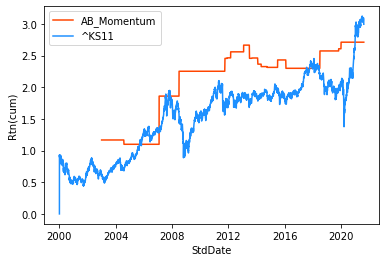

In [41]:
# 
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.set_xlabel('StdDate')
ax1.set_ylabel('Rtn(cum)')
line1 = ax1.plot(result['Date'],result['acc return'],color='orangered', label ='AB_Momentum')
line2 = ax1.plot(result['Date'],result['acc return_BM'],color='dodgerblue', label =TICKER)
lines =line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines,labels)

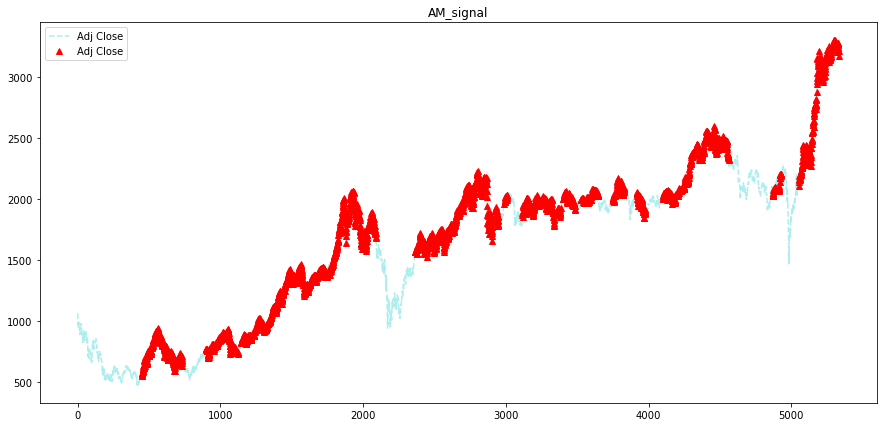

In [43]:
# 절대모멘텀 signal
plt.figure(figsize=(15,7))
plt.title('AM_signal')
result['Adj Close'].plot(color = 'paleturquoise',linestyle='--')
result[result['signal']==1]['Adj Close'].plot(color='r', linestyle='None', marker='^')
plt.legend()
plt.show()